# Parse Logger Files

1. Parse binary
    * ```read_records```
2. Sync GPS to ADC time
    * ```sync_adc_time```
3. Apply appropriate binning to ADC values
    * ```adc_binning```
4. Interpolate GPS coordinates to bin time
    * ```interpolate_coords```
5. Get maintenance logbook quality flags
    * ```lib_reports```
6. Get metadata and encoding
    * ```pyrnet_cfmeta_l1b.json```
7. Calculate sun position
    * ```trosat.sunpos```
8. Make xarray Dataset
9. Drop first and last 5min of data to avoid bad data due to maintenance

In [1]:
#|hide
#|default_exp logger

In [2]:
#|export
from numpy.typing import NDArray,ArrayLike
import re
import gzip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import linregress
import logging
from toolz import assoc_in
import pkg_resources as pkg_res

from trosat import sunpos as sp

from pyrnet import utils
from pyrnet import reports

# logging setup
logging.basicConfig(
    filename='pyrnet.log',
    encoding='utf-8',
    level=logging.DEBUG,
    format='%(asctime)s %(name)s %(levelname)s:%(message)s'
)
logger = logging.getLogger(__name__)


# Local variables
_nat      = np.datetime64('NaT','ms')
_re_gprmc = re.compile('^(\d+,\d+ \d) \$GPRMC,(.*)(\*\w{2})$')
_re_adc   = re.compile('^(\d+)(\s\d+)+$')

In [3]:
import datetime as dt
import matplotlib.pyplot as plt

## 1. Reading binary files from the Logger
Open and read the binary files from the logger. These files have a header of 8 lines

If the Logger receives power, it immediately starts to write data to the file. The first voltage measurements are good, but the GPS signal needs some time to establish.

If Logger writes data item per item, so if turned off, the file ends in an incomplete line most of the time. Sometimes, the last information is a GPS line. This events have to be handled.

### reading the binary:

In [4]:
#|dropout
fname = "../../example_data/Pyr9_000.bin"
if fname[-3:]=='.gz':
    f = gzip.open(fname,'rt',errors='ignore') # open in text mode, ignore non UTF8 characters
else:
    f = open(fname,'r',errors='ignore')
lines =[l.rstrip() for l in f.readlines()]
f.close()

print("=====Header and Start of Data=====:")
print(*lines[:15], sep='\n')
print('\n...\n')
print("==========End of Data=============:")
print(*lines[-10:], sep='\n')

=====Header and Start of Data=====:
# - TROPOS - Pyranometer Network BOX 9
#FIRMWARE: Logomatic Kwan v1.1 (modified Witthuhn 201803) Aug 23 2018 10:43:35
#    MAM setup: MAMCR=2, MAMTIM=4
#    SD Card Setup: result=3,   MID=3,   OID='SD',   PNM='SU02G',   PRV=128,   PSN=321248437
#    IDs: TROPOS_ID: A201300109 ; BOX: 9 ; WTS: 9
#        Pyr9 - serial:S12128.009 ; Pyr62 - serial:S12137.012
#    Calibration: Pyr9: 7.460000 (201504) ; Pyr62: 7.590000 (201504)
# time [ms] , [counts]...
891 836 322 484 194 1000 180
991 836 322 484 194 998 180
91 836 322 484 194 999 180
20800108,112102 0 $GPRMC,112102.067,V,,,,,0.00,0.00,080180,,,N*4C
191 836 322 485 194 1000 180
291 837 324 485 194 998 181
391 836 324 485 194 998 180

...

==========End of Data=============:
791 834 322 488 194 1000 180
891 835 323 488 194 998 180
991 834 322 486 194 998 180
91 835 322 486 194 997 180
191 838 322 486 194 1000 180
20030114,112109 0 $GPRMC,112109.000,A,5123.4125,N,01153.1148,E,0.21,0.00,140103,,,A*6D
291 836

### cleanup
*  Skip almost empty files (data lines <20)
*  remove the last line as it is probably incomplete
*  check again if now a GPS line is the last line and remove it if so

In [5]:
# remove last line -> mostly damaged or empty
lines=lines[:-1]
# remove gps line at the end -> else processing issues
if _re_gprmc.match(lines[-1]):
    lines=lines[:-1]

### Divide GPS and ADC records
GPS and ADC lines have to be parsed separately

In [6]:
#|dropout
gpslines = []
adclines = []
for i,l in enumerate(lines):
    m = _re_gprmc.match(l)
    if m:
        gpslines.append(l)
        # -> send to parse_gps function
    elif _re_adc.match(l):
        adclines.append(l)
        # -> send to parse_adc function
    else:
        # unhandled record...
        pass

print("GPS lines:")
print(*gpslines, sep="\n")
print()
print("ADC lines:")
print(*adclines[:10], sep="\n")
print("...")

GPS lines:
20800108,112102 0 $GPRMC,112102.067,V,,,,,0.00,0.00,080180,,,N*4C
20800108,112103 0 $GPRMC,112103.067,V,,,,,0.00,0.00,080180,,,N*4D
20030114,112104 0 $GPRMC,112104.065,A,5123.4127,N,01153.1153,E,0.06,0.00,140103,,,A*6E
20030114,112105 0 $GPRMC,112105.065,A,5123.4127,N,01153.1154,E,0.05,0.00,140103,,,A*6B
20030114,112107 0 $GPRMC,112107.000,A,5123.4126,N,01153.1151,E,0.14,0.00,140103,,,A*6E
20030114,112108 0 $GPRMC,112108.000,A,5123.4126,N,01153.1150,E,0.20,0.00,140103,,,A*67
20030114,112109 0 $GPRMC,112109.000,A,5123.4125,N,01153.1148,E,0.21,0.00,140103,,,A*6D

ADC lines:
891 836 322 484 194 1000 180
991 836 322 484 194 998 180
91 836 322 484 194 999 180
191 836 322 485 194 1000 180
291 837 324 485 194 998 181
391 836 324 485 194 998 180
491 836 322 484 194 1000 181
591 836 322 484 194 999 180
691 837 322 484 194 998 180
791 829 322 484 194 1000 180
...


### Parsing GPS
Workflow:
1. Look if GPS is available (Status:*A*) if not return nan
2. Read lat,lon and time information
3. Account for GPS rollover

The GPS chip in use has no automatic patch to account for GPS week integer rollover, which happend at 2019-04-06. Measurements taken after this date, have to add 1024 weeks to the date the GPS provides. Therefore this parsing function requires the measurement date (to process older campaigns).

In [7]:
#|export
def parse_gprmc(s, date_of_measure=np.datetime64('now')):
    '''
    Parse a string with a GPRMC GPS record

    Parameters
    ----------
    s: string
        A GPRMC record
    date_of_measure: datetime or datetime64
        A rough time, when the measurements happen to account for GPS rollover.
        Precise datetime is only necessary for the period of 2019-05-06 to 2019-08-17.
        Otherwise, providing a year is sufficient.
        The default is np.datetime64("now"), which is sufficient for all measurements conducted later than 2019-08-17.

    Returns
    -------
    gprmc : tuple
        A tuple with datetime64,status,lat,lon
    '''
    date_of_measure = utils.to_datetime64(date_of_measure)
    # split fields of GPRMC record
    f = s.split(',')
    status = f[1]
    if status=='A':
        try:
            # parse latitude
            lat = float(f[2][:2])+float(f[2][2:])/60
            if f[3]=='S':
                lat *= -1.0
            # parse longitude
            lon = float(f[4][:3])+float(f[4][3:])/60
            if f[5]=='W':
                lon *= -1.0
            if date_of_measure>np.datetime64("2019-04-06") and date_of_measure<np.datetime64("2019-08-17"): #account for gps week rollover
                YY = '19'+f[8][4:6]
            else:
                YY = "20"+f[8][4:6]
            mm = f[8][2:4]
            dd = f[8][0:2]
            HH = f[0][0:2]
            MM = f[0][2:4]
            SS = f[0][4:]
            dt = np.datetime64(YY+'-'+mm+'-'+dd+'T'+HH+':'+MM+':'+SS,'ms')
            if date_of_measure>np.datetime64("2019-04-06"): #account for gps week rollover -> date jump 1024 weeks back at 2019-04-06
                dt= dt+np.timedelta64(1024,'W')
            r = (dt,status,lat,lon)
        except:
            return (_nat,'V',np.nan,np.nan)
    else:
        r = (_nat,'V',np.nan,np.nan)
    return r

### Parse ADC
The ADC output are simple tab separated voltage values of the 5 analog input pins of the Logger.
#### ADC (3.3V, 10bit) Analog In Pins:
* [0] Internal Battery measure
* [1] Temperature sensor (0-5V, measured with voltage split)
* [2] Humidity sensor (0-5V, measured with voltage split)
* [3] Pyranometer main (0  -$\mathrm{gain}*\mathrm{F}*\mathrm{C}$ V)
* [4] Battery (0-6V, measured with voltage split (same resistors))
* [5] None
* [6] Pyranometer secondary platform (0 - $\mathrm{gain}*\mathrm{F}*\mathrm{C}$ V)
* [7] None
* [8] None

with $\mathrm{gain}=300$, surface irradiance $\mathrm{F}$ of 0-1500 Wm-2, and calibration factor $\mathrm{C} < 8e-6 V\,Wm-2$, the voltage range of the pyranometer sensors spans the full available range (0-3.3V) depending on the calibration factor.

> *None* column won't appear in raw output file

> The first column is always milliseconds of processor runtime.

In [8]:
#|export
def parse_adc(s):
    '''
    Parse an ADC record

    Parameters
    ----------
    s: string
        The ADC record

    Returns
    -------
    t: tuple
       A tuple of digital counts of the ADC
    '''
    return tuple(map(int,s.split()))

### Putt all together
This function reads the logger file, separates GPS and ADC records, wich will be parsed by the functions introduced above. Then the data is collected

In [9]:
#|export
dtype_gprmc = [
    ( 'time',   'datetime64[ms]' ),
    ( 'status', 'S1' ),
    ( 'lat',    'f8' ),
    ( 'lon',    'f8' ),
    ( 'iadc',   'u4' )
]

def read_records(fname: str,
                 date_of_measure: np.datetime64 = np.datetime64('now')) -> (NDArray, NDArray):
    '''
    Read the GPRMC and ADC records from the pyranometer logger files

    Parameters
    ----------
    fname: string
        The filename of the logger file
    date_of_measure: numpy.datetime64
        Date of measurement to account for gps rollover

    Returns
    -------
    rec_adc: ndarray
        The 10bit ADC readings
    rec_gprmc: recarray
        The GPRMC GPS records
    '''
    logger.info(f"Start reading records from file: {fname}")
    date_of_measure = utils.to_datetime64(date_of_measure)
    # Read file, use errors='ignore' to skip non UTF-8 characters
    # non UTF-8 characters may arise in broken GPS strings from time to time
    if fname[-3:]=='.gz':
        f = gzip.open(fname,'rt',errors='ignore') # open in text mode, ignore non UTF8 characters
    else:
        f = open(fname,'r',errors='ignore')
    lines =[l.rstrip() for l in f.readlines()]
    f.close()

    ##- skip almost empty files
    if len(lines)<20:
        logger.info("Skip file, as number of records is < 20.")
        return False,False

    # remove last line -> mostly damaged or empty
    lines=lines[:-1]
    # remove gps line at the end -> else processing issues
    if _re_gprmc.match(lines[-1]):
        lines=lines[:-1]

    rec_gprmc = []
    rec_adc = []
    iadc = 0
    for i,l in enumerate(lines):
        m = _re_gprmc.match(l)
        if m:
            r = parse_gprmc(m.group(2), date_of_measure)
            if not np.isnat(r[0]):
                # add number of adc values before GPS line
                rec_gprmc.append(r+(iadc,))
        elif _re_adc.match(l):
            r = parse_adc(l)
            if iadc==0:
                adc_len=len(r)
            # if record line is incomplete (due to power cut off)
            # the line is dropped
            if len(r)==adc_len:
                rec_adc.append(r)
                iadc += 1
        else:
            # unhandled record...
            pass
    rec_adc   = np.array(rec_adc,dtype=np.uint16)
    rec_gprmc = np.array(rec_gprmc,dtype=dtype_gprmc).view(np.recarray)
    logger.info("Done reading records from raw file.")
    return rec_adc, rec_gprmc

In [10]:
rec_adc, rec_gprmc = read_records(fname)

In [11]:
#|dropout
rec_gprmc

rec.array([('2022-08-30T11:21:04.065', b'A', 51.39021167, 11.885255  , 26),
           ('2022-08-30T11:21:05.065', b'A', 51.39021167, 11.88525667, 35),
           ('2022-08-30T11:21:07.000', b'A', 51.39021   , 11.88525167, 54),
           ('2022-08-30T11:21:08.000', b'A', 51.39021   , 11.88525   , 64),
           ('2022-08-30T11:21:09.000', b'A', 51.39020833, 11.88524667, 74)],
          dtype=[('time', '<M8[ms]'), ('status', 'S1'), ('lat', '<f8'), ('lon', '<f8'), ('iadc', '<u4')])

In [12]:
#|dropout
rec_adc

array([[ 891,  836,  322,  484,  194, 1000,  180],
       [ 991,  836,  322,  484,  194,  998,  180],
       [  91,  836,  322,  484,  194,  999,  180],
       [ 191,  836,  322,  485,  194, 1000,  180],
       [ 291,  837,  324,  485,  194,  998,  181],
       [ 391,  836,  324,  485,  194,  998,  180],
       [ 491,  836,  322,  484,  194, 1000,  181],
       [ 591,  836,  322,  484,  194,  999,  180],
       [ 691,  837,  322,  484,  194,  998,  180],
       [ 791,  829,  322,  484,  194, 1000,  180],
       [ 891,  834,  322,  485,  194,  999,  180],
       [ 991,  836,  323,  486,  194, 1000,  181],
       [  91,  836,  324,  484,  194,  998,  180],
       [ 191,  836,  322,  483,  194,  998,  180],
       [ 291,  836,  322,  484,  194,  998,  180],
       [ 391,  835,  322,  484,  194, 1000,  180],
       [ 491,  836,  323,  484,  194,  998,  180],
       [ 591,  836,  322,  485,  194,  999,  180],
       [ 691,  836,  323,  486,  194,  999,  180],
       [ 791,  836,  322,  484,

## 2. Sync GPS time to ADC records
The ADC is timed internally by the processor clock. This is prone to be not accurate. The following function attaches the GPS time to ADC samples in between two GPS lines by linear regression.

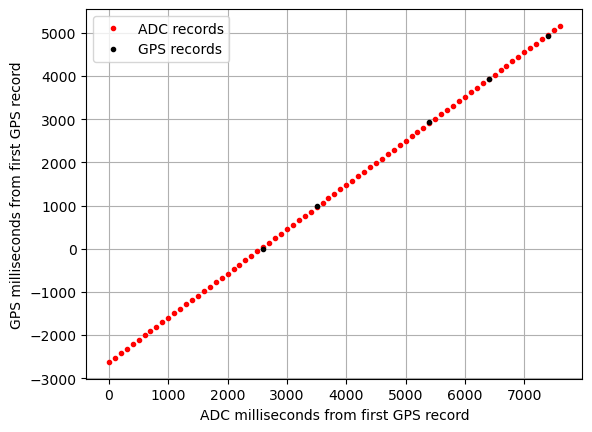

In [13]:
# get millisecond part
ta = rec_adc[:,0].astype('timedelta64[ms]')
# get time difference between records
dt = np.diff(ta)
dt[dt<np.timedelta64(-850,'ms')] += 1000
# get cummulative time offset rel. to first ADC record
ta[0] = 0
ta[1:] = np.cumsum(dt)
### 2. Get logger clock for GPRMC records
# get time of previous ADC record
t1 = ta[rec_gprmc.iadc]/np.timedelta64(1,'ms')
# time of GPS records from GPRMC record
t2 = (rec_gprmc.time-rec_gprmc.time[0])/np.timedelta64(1,'ms')
a,b = linregress(t1,t2)[:2]
t = rec_gprmc.time[0]+ta*a+b.astype('timedelta64[ms]')

fig,ax = plt.subplots(1,1)
_ = ax.plot(ta/np.timedelta64(1,'ms'),
            a*ta/np.timedelta64(1,'ms')+b,
            'r.', label='ADC records')
_ = ax.plot(t1,t2,'k.', label='GPS records')
_ = ax.grid(True)
_ = ax.legend()
_ = ax.set_ylabel("GPS milliseconds from first GPS record")
_ = ax.set_xlabel("ADC milliseconds from first GPS record")
fig.show()


In [14]:
#|export
def sync_adc_time(rec_adc, rec_gprmc):
    '''
    Synchronize the ADC time to the GPS records

    Parameters
    ----------
    rec_adc: ndarray
        The digital counts of the ADC from the logger file
    rec_gprmc: recarray
        The GPRMC records from the logger file

    Returns
    -------
    time: ndarray(datetime64[ms])
        The time of the ADC records
    '''
    ### 1. Reconstruct logger clock
    # get millisecond part
    ta = rec_adc[:,0].astype('timedelta64[ms]')
    # get time difference between records
    dt = np.diff(ta)
    dt[dt<np.timedelta64(-850,'ms')] += 1000
    # get cummulative time offset rel. to first ADC record
    ta[0] = 0
    ta[1:] = np.cumsum(dt)
    ### 2. Get logger clock for GPRMC records
    # get time of previous ADC record
    t1 = ta[rec_gprmc.iadc]/np.timedelta64(1,'ms')
    # time of GPS records from GPRMC record
    t2 = (rec_gprmc.time-rec_gprmc.time[0])/np.timedelta64(1,'ms')
    a,b = linregress(t1,t2)[:2]
    t = rec_gprmc.time[0]+ta*a+b.astype('timedelta64[ms]')

    logger.info('Sync ADC time to GPS Fit Summary:')
    logger.info('|-- Drift  : {0:7.2f} [s/day]'.format( (1/a-1)*86400 ))
    logger.info('|-- Slope  : {0:13.8f}'.format(a))
    logger.info('|-- Offset : {0:7.2f} [s]'.format(b/1000))
    logger.info('|-- Jitter : {0:7.2f} [ms]'.format(np.std(t2-(a*t1+b))))
    return t

In [15]:
#|dropout
time = sync_adc_time(rec_adc,rec_gprmc)
time

array(['2022-08-30T11:21:01.443', '2022-08-30T11:21:01.545',
       '2022-08-30T11:21:01.647', '2022-08-30T11:21:01.750',
       '2022-08-30T11:21:01.852', '2022-08-30T11:21:01.955',
       '2022-08-30T11:21:02.057', '2022-08-30T11:21:02.160',
       '2022-08-30T11:21:02.262', '2022-08-30T11:21:02.364',
       '2022-08-30T11:21:02.467', '2022-08-30T11:21:02.569',
       '2022-08-30T11:21:02.672', '2022-08-30T11:21:02.774',
       '2022-08-30T11:21:02.877', '2022-08-30T11:21:02.979',
       '2022-08-30T11:21:03.081', '2022-08-30T11:21:03.184',
       '2022-08-30T11:21:03.286', '2022-08-30T11:21:03.389',
       '2022-08-30T11:21:03.491', '2022-08-30T11:21:03.594',
       '2022-08-30T11:21:03.696', '2022-08-30T11:21:03.799',
       '2022-08-30T11:21:03.901', '2022-08-30T11:21:04.003',
       '2022-08-30T11:21:04.106', '2022-08-30T11:21:04.208',
       '2022-08-30T11:21:04.311', '2022-08-30T11:21:04.413',
       '2022-08-30T11:21:04.516', '2022-08-30T11:21:04.618',
       '2022-08-30T11:21

## 3. Binning of ADC values
The original time resolution is about 10Hz. Here we apply binning of ADC samples to a regular spaced time grid.

We declare *bins* as the desired number of bins per day, e.g. ```bins = 86400``` one bin every second.

In [16]:
# Desired bins per day
bins = 86400

Now we can calculate the bin number each sample is assigned to.

In [17]:
# starting day
t0 = time[0].astype('datetime64[D]')
# convert time to 'days from t0'
dday = (time-t0)/np.timedelta64(1,'D')
# calculate the bin number assigned to every sample
it = np.int64(dday*bins)
it

array([40861, 40861, 40861, 40861, 40861, 40861, 40862, 40862, 40862,
       40862, 40862, 40862, 40862, 40862, 40862, 40862, 40863, 40863,
       40863, 40863, 40863, 40863, 40863, 40863, 40863, 40864, 40864,
       40864, 40864, 40864, 40864, 40864, 40864, 40864, 40864, 40865,
       40865, 40865, 40865, 40865, 40865, 40865, 40865, 40865, 40865,
       40866, 40866, 40866, 40866, 40866, 40866, 40866, 40866, 40866,
       40866, 40867, 40867, 40867, 40867, 40867, 40867, 40867, 40867,
       40867, 40867, 40868, 40868, 40868, 40868, 40868, 40868, 40868,
       40868, 40868, 40869, 40869, 40869])

Calculate number of samples per bins (*cnt*) and a bin index starting with the first bin (*inv_idx*)

In [18]:
uval,inv_idx,cnt = np.unique(it,return_inverse=True,return_counts=True)
uval,inv_idx,cnt

(array([40861, 40862, 40863, 40864, 40865, 40866, 40867, 40868, 40869]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8]),
 array([ 6, 10,  9, 10, 10, 10, 10,  9,  3]))

Now [np.bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) can be used to calculate the average value of the samples in every bin.

In [19]:
binvalues = np.bincount(inv_idx,weights=rec_adc[:,2])/cnt
print('rec_adc values of the fist bin, 3rd column')
print(rec_adc[inv_idx==0,2])
print("Average calculated with bincount:")
print(binvalues[0])

rec_adc values of the fist bin, 3rd column
[322 322 322 322 324 324]
Average calculated with bincount:
322.6666666666667


Time values for each bin are assigned as the starting boundary of the sample times within the bin.

In [20]:
# assign bin time
bintime = t0+ np.timedelta64(86400000,'ms')*uval.astype(np.float64)/bins
print('sample time for the fist bin:')
print(time[inv_idx==0])
print("Assigned bin time:")
print(bintime[0])

sample time for the fist bin:
['2022-08-30T11:21:01.443' '2022-08-30T11:21:01.545'
 '2022-08-30T11:21:01.647' '2022-08-30T11:21:01.750'
 '2022-08-30T11:21:01.852' '2022-08-30T11:21:01.955']
Assigned bin time:
2022-08-30T11:21:01.000


In [21]:
#|export
def adc_binning(rec_adc, time, bins=86400):
    """
    Binning and averaging of ADC samples

    Parameters
    ----------
    rec_adc: ndarray
        The ADC records parsed from the logger.
    time: ndarray of time objects
        Sample time of ADC records.
    bins: int
        Number of desired bins per day. The default is 86400, which result in
        mean values of 1 second steps per day. Maximum resolution is 86400000.

    Returns
    -------
    ndarray, ndarray(datetime64)
        Binned ADC records and corresponding time.
    """
    time = utils.to_datetime64(time)
    # starting day
    t0 = time[0].astype('datetime64[D]')
    # convert time to 'days from t0'
    dday = (time-t0)/np.timedelta64(1,'D')
    # calculate time bins of output dataset
    it = np.int64(dday*bins)
    # index for unique bins (inv_idx) and count of samples per bin (cnt)
    uval, inv_idx, cnt = np.unique(it,
                                   return_inverse=True,
                                   return_counts=True)
    logger.info(f"ADC records fill {len(uval)} bins of data.")
    # Calculate average of sample values per bin
    # The first two columns of rec_adc will be omitted as they store the
    # internal measures for timing and battery (first two columns)
    V = np.zeros((len(uval),rec_adc.shape[1]-2))
    for i in range(V.shape[1]):
        V[:,i] = np.bincount(inv_idx,weights=rec_adc[:,i+2])/cnt
    bintime = t0+ np.timedelta64(86400000,'ms')*uval.astype(np.float64)/bins
    logger.info(f"ADC records span a time period from {bintime[0]} to {bintime[-1]}.")
    return V, bintime

## 4. Interpolate GPS coordinates

In [22]:
#|export
def interpolate_coords(rec_gprmc, time):
    """
    Interpolate lat and lon from gps records

    Parameters
    ----------
    rec_gprmc: recarray
        The GPRMC records from the logger file
    time: list or array of time objects

    Returns
    -------
    ndarray, ndarray
        lat and lon interpolated from GPS records to `time`
    """
    time = utils.to_datetime64(time)
    t0 = time[0].astype('datetime64[D]')
    # coordinate variables
    x1 = (time-t0)/np.timedelta64(1,'ms')
    x2 = (rec_gprmc.time-t0)/np.timedelta64(1,'ms')
    lat = np.interp(x1,x2,rec_gprmc.lat)
    lon = np.interp(x1,x2,rec_gprmc.lon)
    return lat, lon

## 5. To xarray

### Encoding
The encoding attributes are defined within the file PyrNet/share/pyrnet_cfmeta_l1b.json per default.

The netcdf packing of data is realized via the two attributes *scale_factor* and *add_offset*:
  ```unpacked_variable = scale_factor * packed_variable + add_offset```


**irradiance values**:

Irradiance values are stored as Voltage for later calibration. Assigning 1500Wm-2 as maximum measurable irradiance from the irradiance sensor. The maximum counts (*valid_max*) measured by the logger can be calculated by:
 * maximum counts = $\mathrm{gain}*1500*\mathrm{C_{max}}*1023/3.3$

Most calibration factors are in the area of 7.5 uV/Wm-2, assuming $\mathrm{C_{max}}=8$uV/Wm-2 for this estimate seems sufficient. All radiation sensors are amplified with a fixed gain of $\mathrm{gain}=300$.

Later (level 1c+) the scale factor will be instrument specific by adding the calibration from V to W m-2

**temperature and humidity**:


Calibration coefficients for Temperature and Humidity DKRF-4000 series (discontinued) https://www.driesen-kern.de/downloads/produktlinie_feuchte.pdf are:
 * Temperature (T) range :-20-80 degC  from 0-5V
 * relative Humidity (rH) range: 0-100% from 0-5V

As the logger ADC range is 0-3.3V with a 10bit resolution, the sensors are measured through a voltage splitting circuit. Therefore, the ADC counts have to be doubled.
 * Voltage U [V] = $2* 3.3/1023$ [counts]
 * T = $-20 + 100*(U/5)$ [degC] = $253.15 + 100*(U/5)$ [K]
 * rH = $(U/5)$  [%]  = $(U/5)$    [%]

**ancillary data**:

* solar zenith angle (*szen*)
    * valid range unpacked: (0,180) (deg)
    * packing in u2 integer (unsigned 16bit)
        * fill value = $2^{16} - 1$
        * scale_factor = $180 /(2^{16}-2)$
* solar azimuth angle (*sazi*)
    * valid range unpacked: (0,360)
    * packing in u2 integer (unsigned 16bit)
        * fill_value = $2^{16} -1$
        * scale_factor= $360 / (2^{16}-2)$
* earth sun distance (*esd*)
    * valid range unpacked: (0.98,1.02)
    * packing in u2 integer (unsigned 16bit)
        * fill_value = $2^{16} -1$
        * scale_factor= $(1.02-0.98)/(2^{16}-2)$
        * add_offset = 0.98



In [23]:
#|dropcode
#|dropout
# temperature from counts
print(f"scale_factor temperature: {20.*2*3.3/1023} K/count")
print(f"add_offset temperature: 253.15 K")
print(f"valid_range temperature: [0, {5*1023/6.6}]")
print()
# humidity from counts
print(f"scale_factor relative humidity: {2*3.3/1023} %/count")
print(f"add_offset relative humidity: 0.0 ")
print(f"valid_range relative humidity: [0, {5*1023/6.6}]")
print()
# battery voltage from counts
print(f"scale_factor battery_voltage: {2*3.3/1023} V/count")
print(f"add_offset battery_voltage: 0.0 ")
print(f"valid_range battery_voltage: [0, {6.4*1023/6.6}]")
print()
# flux to Voltage from counts
print(f"scale_factor radflux (V): {3.3/1023} V/count")
print(f"add_offset radflux (V): 0.0 ")
print(f"valid_range radflux (V): [0, {300*1500*8*1e-6*1023/3.3}] -> requires full range (0-1023)")
print()
# szen encoding
print(f"scale_factor szen (deg): {180./(36_000)}")
print(f"add_offset szen: 0.0 ")
print(f"valid_range szen: [0, {36_000}]")
print()
# sazi encoding
print(f"scale_factor sazi (deg): {360./(36_000)}")
print(f"add_offset sazi: 0.0 ")
print(f"valid_range sazi: [0, {36_000}]")
print()
# esd encoding
print(f"scale_factor esd (AU): {(1.02-0.98)/(40_000)}")
print(f"add_offset esd: 0.98 ")
print(f"valid_range esd: [0, {40_000}]")
print()
# lat encoding
print(f"scale_factor lat (degree_north): {(90.-(-90.))/180_000_000}")
print(f"add_offset lat (degree_north): -90.")
print(f"valid_range lat: [0, 180_000_000]")
print()
# lon encoding
print(f"scale_factor lon (degree_east): {(180.-(-180.))/360_000_000}")
print(f"add_offset lon (degree_east): -180.")
print(f"valid_range lon: [0, 360_000_000]")
print()


scale_factor temperature: 0.12903225806451613 K/count
add_offset temperature: 253.15 K
valid_range temperature: [0, 775.0]

scale_factor relative humidity: 0.0064516129032258064 %/count
add_offset relative humidity: 0.0 
valid_range relative humidity: [0, 775.0]

scale_factor battery_voltage: 0.0064516129032258064 V/count
add_offset battery_voltage: 0.0 
valid_range battery_voltage: [0, 992.0000000000001]

scale_factor radflux (V): 0.0032258064516129032 V/count
add_offset radflux (V): 0.0 
valid_range radflux (V): [0, 1116.0] -> requires full range (0-1023)

scale_factor szen (deg): 0.005
add_offset szen: 0.0 
valid_range szen: [0, 36000]

scale_factor sazi (deg): 0.01
add_offset sazi: 0.0 
valid_range sazi: [0, 36000]

scale_factor esd (AU): 1.0000000000000008e-06
add_offset esd: 0.98 
valid_range esd: [0, 40000]

scale_factor lat (degree_north): 1e-06
add_offset lat (degree_north): -90.
valid_range lat: [0, 180_000_000]

scale_factor lon (degree_east): 1e-06
add_offset lon (degree_ea

In [24]:
#|export
def read_logger(
        fname : str,
        *,
        station: int,
        report: dict,
        bins : int = 86400,
        date_of_measure : np.datetime64 = np.datetime64("now"),
        config: dict|None = None,
        global_attrs: dict|None = None
) -> xr.Dataset:
    """
    Read logger binary file and parse it to xarray Dataset. Thereby, attributes and names are defined via cfmeta.json file and sun position values are calculated and added.

    Parameters
    ----------
    fname: str
        Path and filename of the raw logger file.
    station: int
        PyrNet station box number.
    report: dict
        Parsed maintenance report, see lib_reports.ipynb
    bins: int
        Number of desired bins per day. The default is 86400, which result in
        mean values of 1 second steps per day. Maximum resolution is 86400000.
    date_of_measure: float, datetime or datetime64
        A rough date of measure  to account for GPS week rollover. If measured in 2019, day resolution is recommended, before 2019 annual resolution, 2020 onwards not required. If float, interpreted as Julian day from 2000-01-01T12:00. the default is np.datetime64("now").
    config: dict
        Stores processing specific configuration.
            * cfjson -> path to cfmeta.json, the default is "../share/pyrnet_cfmeta_l1b.json"
            * stripminutes -> number of minutes to be stripped from the data at start and end,
                the default is 5.
    global_attrs: dict
        Additional global attributes for the Dataset. (Overrides cfmeta.json attributes)
    Returns
    -------
    xarray.Dataset
        Raw Logger data for one measurement periode.
    """
    fn_cfjson = pkg_res.resource_filename("pyrnet", "share/pyrnet_cfmeta_l1b.json")

    default_config = {
            "campaign": "",
            "project": "",
            "creator_name": "",
            "contributor_name": "",
            "contributor_role": "",
            "notes": "",
            "cfjson": fn_cfjson,
            "stripminutes": 5,
        }
    if config is None:
        config = default_config
    config = {**default_config, **config}


    if global_attrs is None:
        global_attrs = {}

    date_of_measure = utils.to_datetime64(date_of_measure)

    # 1. Parse binary
    rec_adc, rec_gprmc = read_records(fname=fname, date_of_measure=date_of_measure)

    if type(rec_adc)==bool or len(rec_gprmc.time)<3:
        logger.debug("Failed to load the data from the file, because of not enough stable GPS data, or file is empty.")
        return False

    # 2. Sync GPS to ADC time
    adctime = sync_adc_time(rec_adc, rec_gprmc)

    # 3. Apply appropriate binning to ADC values
    adc_counts, bintime = adc_binning(rec_adc, time=adctime, bins=bins)

    # 4. Interpolate GPS coordinates to bin time
    lat, lon = interpolate_coords(rec_gprmc, bintime)

    # 5. Get Logbook maintenance quality flags
    key = f"{station:03d}"
    if key not in report:
        logger.warning(f"No report for station {station} available.")
    qc_main = reports.get_qcflag(
        qc_clean=report[key]['clean'],
        qc_level=report[key]['align']
    )
    qc_extra = reports.get_qcflag(
        qc_clean=report[key]['clean2'],
        qc_level=report[key]['align2']
    )

    # 6. get metadata and encoding
    # parse the json file
    cfdict = utils.read_json(config["cfjson"])

    # get global attributes:
    gattrs = cfdict['attributes']

    # apply config
    gattrs = {k:v.format_map(config) for k,v in gattrs.items()}

    # add additional global attrs
    gattrs.update(global_attrs)

    duration = adctime[-1]-adctime[0]
    resolution = adctime[1] - adctime[0]
    now = pd.to_datetime(np.datetime64("now"))
    gattrs.update({
        'processing_level': 'l1a',
        # 'product_version': '',# TODO: add version
        'date_created': now.isoformat(),
        'geospatial_lat_min': np.nanmin(lat),
        'geospatial_lat_max': np.nanmax(lat),
        'geospatial_lat_units': 'degN',
        'geospatial_lon_min': np.nanmin(lon),
        'geospatial_lon_max': np.nanmax(lon),
        'geospatial_lon_units': 'degE',
        'time_coverage_start': pd.to_datetime(adctime[0]).isoformat(),
        'time_coverage_end': pd.to_datetime(adctime[-1]).isoformat(),
        'time_coverage_duration': pd.to_timedelta(duration).isoformat(),
        'time_coverage_resolution': pd.to_timedelta(resolution).isoformat(),
        'history': f'{now.isoformat()}: Generated level l1a  by pyrnet version XX; ', # TODO: add version info
    })

    # get variable attributes
    d = utils.get_var_attrs(cfdict)

    # split encoding attributes
    vattrs, vencode = utils.get_attrs_enc(d)

    # add qc notes
    vattrs = assoc_in(vattrs, ["ghi_qc","note_general"], report[key]["note_general"])
    vattrs = assoc_in(vattrs, ["gti_qc","note_general"], report[key]["note_general"])
    vattrs = assoc_in(vattrs, ["ghi_qc","note_clean"], report[key]["note_clean"])
    vattrs = assoc_in(vattrs, ["gti_qc","note_clean"], report[key]["note_clean2"])
    vattrs = assoc_in(vattrs, ["ghi_qc","note_level"], report[key]["note_align"])
    vattrs = assoc_in(vattrs, ["gti_qc","note_level"], report[key]["note_align2"])

    # 7. Calc sun position
    szen, sazi = sp.sun_angles(bintime, lat, lon)
    esd = np.mean(sp.earth_sun_distance(bintime))

    # 8. Make xarray Dataset
    count2volt = lambda x: 3.3 * np.float64(x)/1023.
    ds = xr.Dataset(
        data_vars={
            "ghi": (("time","station"), count2volt(adc_counts[:,2])[:,None]), # [V]
            "gti": (("time","station"), count2volt(adc_counts[:,4])[:,None]), # [V]
            "ta": (("time","station"), 253.15 + 20.*2.*count2volt(adc_counts[:,0])[:,None]), # [K]
            "rh": (("time","station"), 0.2*2.*count2volt(adc_counts[:,1])[:,None]), # [-]
            "battery_voltage": (("time","station"), 2.*count2volt(adc_counts[:,3])[:,None]), # [V]
            "lat": (("time","station"), lat[:,None]), # [degN]
            "lon": (("time","station"), lon[:,None]), # [degE]
            "ghi_qc": ("station", [qc_main]),
            "gti_qc": ("station", [qc_extra]),
            "szen": (("time","station"), szen[:,None]),
            "sazi": (("time","station"), sazi[:,None]),
            "esd": esd,
        },
        coords={
            "time": ("time", bintime),
            "station": ("station", [station]),
        },
        attrs=gattrs
    )

    # add attributes to Dataset
    for k,v in vattrs.items():
        if k not in ds.keys():
            continue
        ds[k].attrs = v

    # add encoding to Dataset
    for k,v in vencode.items():
        if k not in ds.keys():
            continue
        ds[k].encoding = v

    ds["time"].encoding.update({
        "units": f"seconds since {np.datetime_as_string(ds.time.data[0], unit='D')}T00:00Z",
    })

    # 9. Drop first and last <stripminutes> minutes of data to avoid bad data due to maintenance
    stripminutes = np.timedelta64(int(config['stripminutes']), 'm')
    tslice = slice(ds.time.values[0] + stripminutes,
                   ds.time.values[-1] - stripminutes)
    ds = ds.sel(time=tslice)

    return ds


In [25]:
#|dropout
fn_report = "../../example_data/results-survey224783.csv"
fn_data = "../../example_data/Pyr9_000.bin"

fn_cfmeta = pkg_res.resource_filename("pyrnet", "share/pyrnet_cfmeta_l1b.json")


# parse report
df_report = reports.get_responses(fn="../../example_data/results-survey224783.csv")
report = reports.parse_report(df_report,
                              date_of_maintenance=np.datetime64("2023-05-08T12:00"))
# read logger file to xarray
ds = read_logger(
    fname=fn_data,
    station=1, # actually test data is from station 9, but test reports are for station 1 and 2 only
    bins=86400, # seconds resolution
    report=report,
    config={"cfjson": fn_cfmeta, "stripminutes": 0},
    global_attrs={"TESTNOTE": "This is a test note."}
)

ds.to_netcdf("../../example_data/read_logger_output.nc")
ds

<xarray.Dataset>
Dimensions:          (time: 9, station: 1)
Coordinates:
  * time             (time) datetime64[ns] 2022-08-30T11:21:01 ... 2022-08-30...
  * station          (station) int64 1
Data variables:
    dflx_sw          (time, station) float64 0.6258 0.6258 ... 0.6258 0.6258
    dflx_sw_2        (time, station) float64 0.5812 0.5813 ... 0.5806 0.5817
    ta_atm           (time, station) float64 294.8 294.7 294.8 ... 294.7 294.8
    rh_atm           (time, station) float64 0.6252 0.6248 ... 0.628 0.6292
    battery_voltage  (time, station) float64 6.444 6.445 6.444 ... 6.449 6.46
    lat              (time, station) float64 51.39 51.39 51.39 ... 51.39 51.39
    lon              (time, station) float64 11.89 11.89 11.89 ... 11.89 11.89
    dflx_sw_qc       (station) int64 9
    dflx_sw_2_qc     (station) int64 7
    szen             (time, station) float64 42.51 42.51 42.51 ... 42.51 42.51
    sazi             (time, station) float64 182.9 182.9 182.9 ... 182.9 182.9
    esd              float64 1.01
Attributes: (12/30)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:01.443000
    time_coverage_end:         2022-08-30T11:21:09.228000
    time_coverage_duration:    P0DT0H0M7.785S
    time_coverage_resolution:  P0DT0H0M0.102S
    history:                   2023-05-23T09:37:24: Generated level l1a  by p...

In [26]:
pd.to_datetime(ds.time.values[0])

Timestamp('2022-08-30 11:21:01')

In [27]:
#|dropout
import netCDF4
netCDF4.Dataset("../../example_data/read_logger_output.nc",'r')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: TROPOS pyranometer network (PyrNet) observations
    institution: Leibniz Institute for Tropospheric Research (TROPOS)
    department: Remote Sensing of Atmospheric Processes
    department_team: Clouds, Aerosol and Radiation
    address: Permoser Str. 15, 04318 Leipzig, Germany
    source: TROPOS pyranometer network (PyrNet)
    contact_person: Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de or rsd-car@tropos.de
    contributor_name: 
    contributor_role: 
    authors_software: Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de
    creator_name: 
    project: 
    references: https://doi.org/10.5194/amt-9-1153-2016
    standard_name_vocabulary: CF Standard Name Table v81
    conventions: CF-1.10, ACDD-1.3
    license: For non-commercial use only
    TESTNOTE: This is a test note.
    processing_level: l1a
    d

In [28]:
#|hide
# Export module
# Requires *nbdev* to export and update the *../lib/logger.py* module
import nbdev.export
import nbformat as nbf
name = "logger"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")